# Importing the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread , imresize
import os
import time

# Parameters

In [57]:
no_latent = 10
lr = 1e-3
epochs = 100

# Declaring functions

In [3]:
# Sigmoid

def sigmoid(x):
    return 1/(1 + np.exp(-x))

#derivative of sigmoid
def deriv_sigmoid(x):
    return np.exp(-x)/((1+ np.multiply(np.exp(-x),np.exp(-x))))

# softmax

def softmax(x):
    out = np.zeros(x.shape)
    for i in range(0,x.shape[0]):
        for j in range(0,x.shape[1]):
            out[i,j] = np.exp(x[i,j])/np.sum(np.exp(x[i]))
    return out

# sum of Squared error

def squared_error(y_train, y_predicted):
    return np.sum(np.multiply(y_train - y_predicted , y_train - y_predicted))

In [21]:
def load_flattened_images(Loc):
    Images = []
    for root, dirs, files in os.walk(Loc):
        for file in files:
            Image = imread(os.path.join(root, file))
            Image = Image / 255.0
            Images.append(Image.flatten())
                
    Images = np.asmatrix(Images)
    print(Images.shape)

    return Images

In [90]:
## fitting the model

def net_fit_vae(x_train , y_train , epochs = 100 , no_latent = 10 , lr = 1e-3):
    input_dim = x_train.shape[1]
    training_samples = x_train.shape[0]
    output_dim = y_train.shape[1]
    costs = []
    x_train = np.hstack((np.ones((training_samples , 1)), x_train))
    #initializig the parameters
    alpha = np.asmatrix(np.random.normal(0,1e-5,(input_dim + 1 , no_latent)))
    gaama = np.asmatrix(np.random.normal(0,1e-5,(input_dim + 1 , no_latent)))
    beta = np.asmatrix(np.random.normal(0,1e-5,(no_latent+1 , output_dim)))
    
    #looping for number of itretions
    for epoch in range(0,epochs):
        mu_raw = x_train * alpha
        mu = sigmoid(mu_raw)
        sigma_raw = x_train * gaama
        sigma = sigmoid(sigma_raw)
        
        #finding z matrix
        z = np.multiply((np.repeat(np.asmatrix(np.random.multivariate_normal(np.zeros((no_latent)) , np.eye(no_latent))), training_samples,axis = 0)) , np.exp(0.5*sigma))+mu
        z_biased = np.asmatrix(np.hstack((np.ones((training_samples,1)),z)))
        
        #finding y matrix
        y_raw = z_biased * beta
        y_predicted = sigmoid(y_raw)
        
        ##finding the cost
        cost = squared_error(y_train , y_predicted) + 0.5*(np.sum(np.square(mu)) + np.sum(np.exp(sigma)) - np.sum(sigma) - no_latent*training_samples)
        costs.append(cost)
        #finding gradient w.r.t beta
        delta = np.multiply((y_predicted - y_train), deriv_sigmoid(y_raw))
        d_beta = z_biased.T * delta
        
        temp_beta = beta[1:,:]
        
        #finding gradient w.r.t alpha
        ss_alpha = np.multiply((delta * temp_beta.T),deriv_sigmoid(mu_raw))
        d_alpha = x_train.T * (ss_alpha + np.multiply(mu , deriv_sigmoid(mu_raw)))

        #finding gradient w.r.t gaama
        ss_beta = np.multiply((delta * temp_beta.T),deriv_sigmoid(sigma_raw))
        d_gaama = x_train.T * (0.5* np.multiply(ss_beta , np.exp(0.5 * sigma)) + np.multiply(np.exp(sigma) , deriv_sigmoid(sigma_raw)) - deriv_sigmoid(sigma_raw))
        
        #updating the weights
        beta = beta - lr * d_beta
        alpha = alpha - lr*d_alpha
        gaama = gaama - lr*d_gaama
#         print(np.max(alpha) , np.max(beta) , np.min(alpha) , np.min(beta))
        print("\nEpoch: " + str(epoch+1) + "   cost : " + str(cost))
    return beta , costs

In [91]:
#prediction

def net_generate(number , weights , no_latent):
    generated = []
    for i in range(0,number):
        x = np.asmatrix(np.random.multivariate_normal(np.zeros((no_latent)) , np.eye(no_latent)))
        x = np.asmatrix(np.hstack(([[1]],x)))
        gen = sigmoid(x * weights)
        gen_image = gen.reshape(28,28)
        generated.append(gen_image)
    return generated

# Generating training data

In [97]:
# x_train = load_flattened_images("/home/snehith/Documents/machine learning/datasets/mnist/mnistasjpg/trainingSet/0")
# np.save("train_set_vae0.npy" , x_train)
x_train = np.asmatrix(np.load("train_set_vae0.npy"))
print(x_train.shape)

(4132, 784)


# Training the Model

In [98]:
# alpha , beta , losses = net_fit(x_Train , y_train_and , hidden_nodes = hidden_nodes , epochs = epochs ,lr = lr)
tic = time.time()
weights , lossses = net_fit_vae(x_train , x_train , no_latent = no_latent , epochs = epochs ,lr = lr)
print("time taken: "+ str(time.time() - tic) + "sec")
# print("\nalpha:\n",alpha ,"\nbeta:\n", beta,"\n" ,"\nloss:\n", losses[epochs-1])
np.save("weights_vae.npy" , weights)
# np.save("beta_weights_vae.npy" , beta)


Epoch: 1   cost : 725086.136243532

Epoch: 2   cost : 322541.51573729515

Epoch: 3   cost : 669175.7539098519

Epoch: 4   cost : 217094.72920800574

Epoch: 5   cost : 235249.71285442586

Epoch: 6   cost : 207249.00742859082

Epoch: 7   cost : 202111.12168735985

Epoch: 8   cost : 1352057.1311466217

Epoch: 9   cost : 893579.1080725547

Epoch: 10   cost : 216532.42286970024

Epoch: 11   cost : 239362.49715282736

Epoch: 12   cost : 293122.44507299695

Epoch: 13   cost : 216216.97785743725

Epoch: 14   cost : 1618535.8314190523

Epoch: 15   cost : 340584.01575966296

Epoch: 16   cost : 1929043.3005736817

Epoch: 17   cost : 263063.90100896836

Epoch: 18   cost : 278276.83750033745

Epoch: 19   cost : 455252.4498715482

Epoch: 20   cost : 266590.7384369603

Epoch: 21   cost : 342828.47516364977

Epoch: 22   cost : 341424.9807052815

Epoch: 23   cost : 242469.1570861982

Epoch: 24   cost : 268553.1406988095

Epoch: 25   cost : 613325.8634369563

Epoch: 26   cost : 335122.8197375136

Epoch

### Predicting

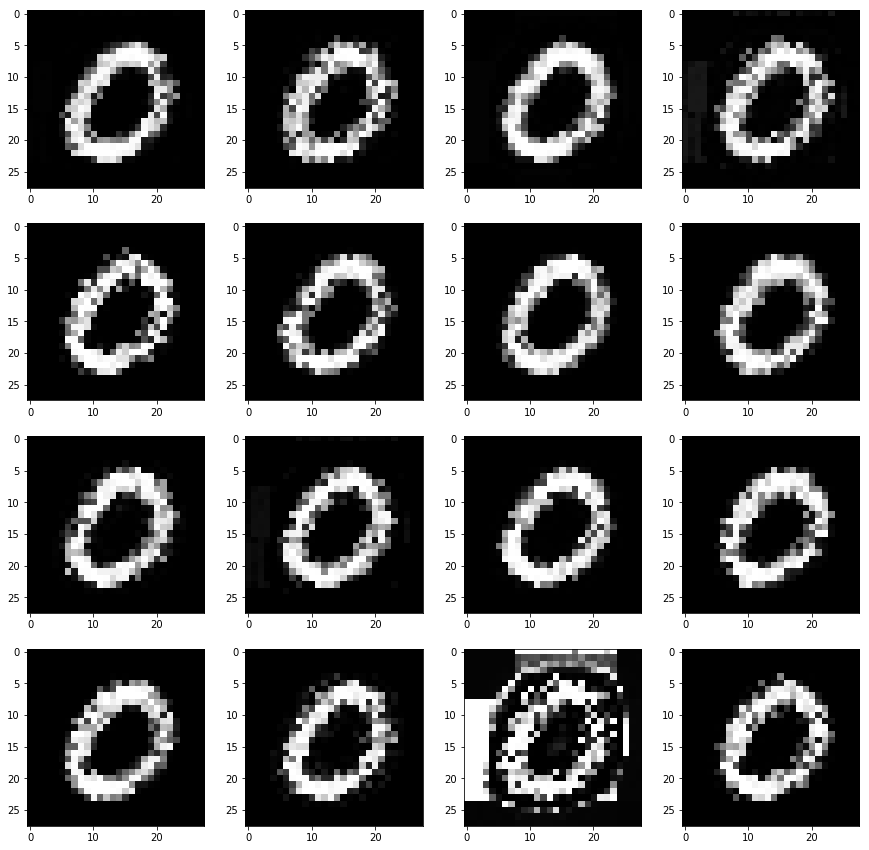

In [102]:
#testing samples
#predicting the output
result = net_generate(16 , weights , no_latent)
# print(np.max(res)  , np.max(x_test))
# print(losses.shape)
plt.figure(figsize = (15,15))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    plt.imshow(result[i] , cmap = 'gray')

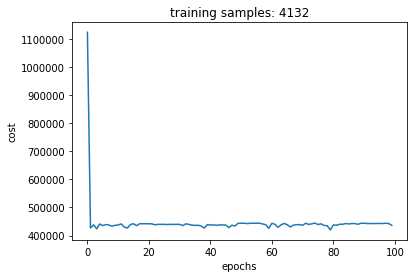

In [100]:
#ploting the cost vs epochs
plt.plot(np.arange(epochs),costs)
# plt.plot(np.arange(epochs),means)
plt.title("training samples: " + str(x_train.shape[0]))
plt.xlabel("epochs")
plt.ylabel("cost")
plt.show()